In [1]:
import os
import pandas as pd
import numpy as np
from fish_helpers import *
import tqdm
import time
from scipy import sparse
import random
from ipypb import ipb
from scipy.stats import pearsonr
base = '/bigstore/binfo/mouse/Hippocampus/'

In [2]:
"""
Loading Data from backup
"""
raw_counts_sparse =  sparse.load_npz(os.path.join(base,'Allen/raw_counts.npz'))
cells = np.array(pd.read_csv(os.path.join(base,'Allen/raw_cells.csv'),index_col=0)['0'])
genes = np.array(pd.read_csv(os.path.join(base,'Allen/raw_genes.csv'),index_col=0)['0'])
metadata = pd.read_csv(os.path.join(base,'sample_annotations.csv'),index_col=0)
good_types = [i for i in metadata['cell_type_alias_label'].unique() if (not 'Doub' in i)&(not 'Quality' in i)&(not 'Unknown' in i)]
metadata = metadata.loc[cells]
raw_counts = raw_counts_sparse.A

/home/zach/miniconda3/envs/pyspots/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (36,54) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
"""
Normalize by cell size
"""
normalized_raw_counts = np.divide(raw_counts,np.sum(raw_counts,axis=0))*10**6
del raw_counts

In [4]:
"""
Generating Cell Type Lookup Table
"""
cell_type_loc = {}
labels = np.array(metadata['cell_type_alias_label'].loc[list(cells)])
for cell_type in np.unique(labels):
    cell_type_loc[cell_type] = np.where(labels==cell_type)[0]

In [74]:
"""
Calculate median and variance for each gene for each cell type
"""
indexes = list(range(len(cells)))
cell_types = cell_type_loc.keys()
n_cell_types = len(cell_types)
ngenes = len(genes)
normalized_cell_type_medians= np.zeros((n_cell_types,ngenes))
normalized_cell_type_averages= np.zeros((n_cell_types,ngenes))
normalized_cell_type_variances = np.zeros((n_cell_types,ngenes))
for i,cell_type in ipb(enumerate(cell_types),n_cell_types):
    loc = cell_type_loc[cell_type]
    if len(loc)>0: # if there are no cells for that node keep as 0?
        cell_type_counts = normalized_raw_counts[:,loc]
        normalized_cell_type_averages[i,:] = np.average(cell_type_counts,axis=1)
        normalized_cell_type_medians[i,:] = np.median(cell_type_counts,axis=1)
        normalized_cell_type_variances[i,:] = np.std(cell_type_counts,axis=1)

 [████████████████████████████████████████████████████████████] 290/290 [05:53<00:04, 1.22s/it]

In [77]:
"""
Calculate median and variance for each gene for permuted cell types
"""
permuted_averages= np.zeros((n_cell_types,ngenes))
permuted_medians= np.zeros((n_cell_types,ngenes))
permuted_variances = np.zeros((n_cell_types,ngenes))
for i,cell_type in ipb(enumerate(cell_types),n_cell_types):
    loc = cell_type_loc[cell_type]
    if len(loc)>0:
        loc = np.array(random.sample(indexes,len(loc)))
        cel_type_counts = normalized_raw_counts[:,loc]
        permuted_averages[i,:] = np.average(cel_type_counts,axis=1)
        permuted_medians[i,:] = np.median(cel_type_counts,axis=1)
        permuted_variances[i,:] = np.std(cel_type_counts,axis=1)

 [████████████████████████████████████████████████████████████] 290/290 [09:21<00:05, 1.94s/it]

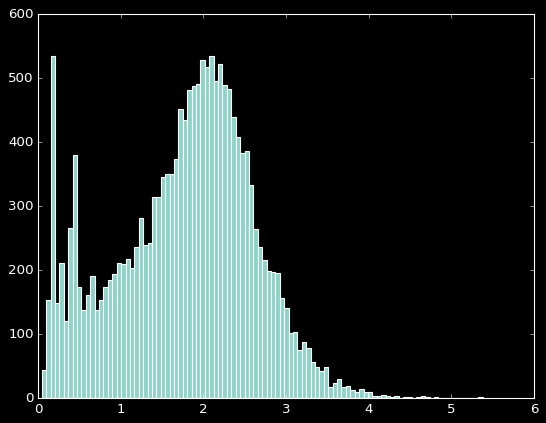

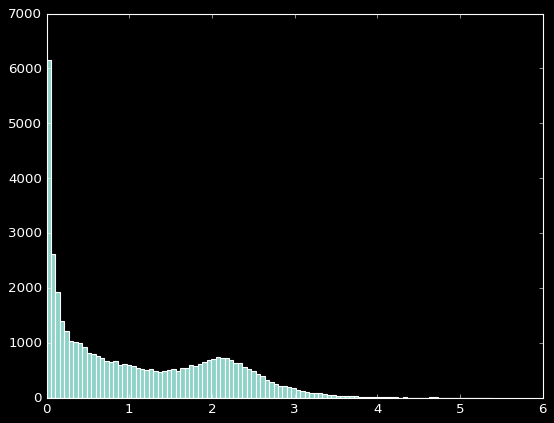

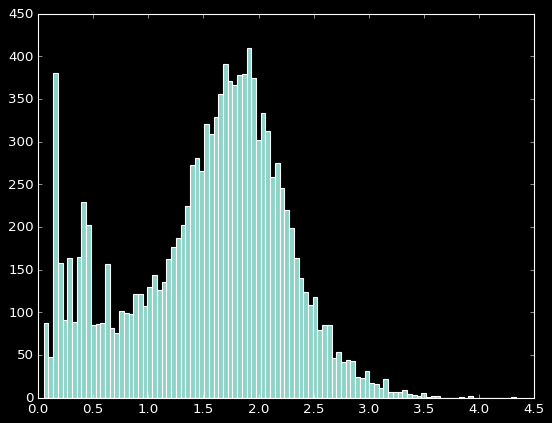

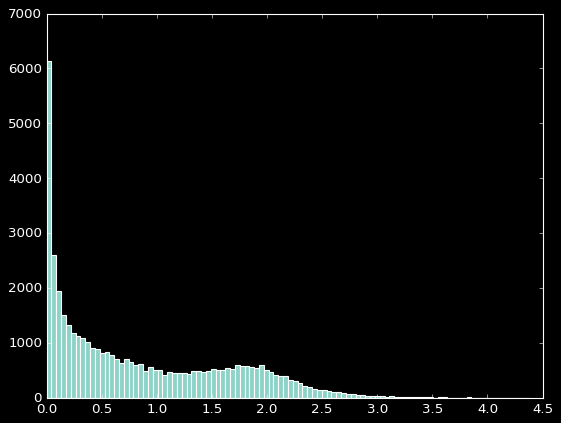

In [120]:
"""
Looking at max median and average of genes
"""
max_cell_type_median = np.max(normalized_cell_type_medians,axis=0)
max_cell_type_average = np.max(normalized_cell_type_averages,axis=0)
max_permuted_median = np.max(permuted_medians,axis=0)
max_permuted_average = np.max(permuted_averages,axis=0)
plt.hist(np.log10(max_cell_type_median[max_cell_type_median>0]+1),bins=100)
plt.show()
plt.hist(np.log10(max_cell_type_average[max_cell_type_average>0]+1),bins=100)
plt.show()
plt.hist(np.log10(max_permuted_median[max_permuted_median>0]+1),bins=100)
plt.show()
plt.hist(np.log10(max_permuted_average[max_permuted_average>0]+1),bins=100)
plt.show()

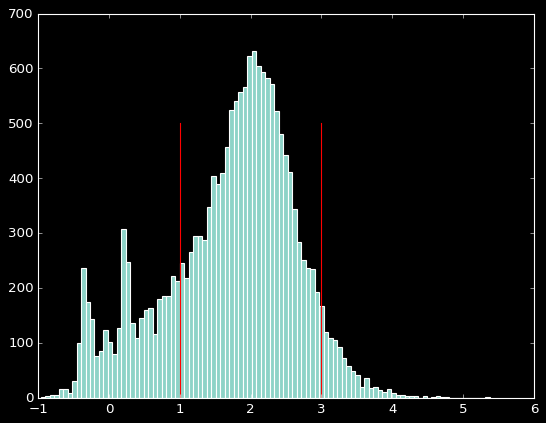

12907


In [130]:
"""
Filter genes by median expression
Remove Genes whose median expression is less than 10
"""
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use('dark_background')
count_min_thresh = 10
count_max_thresh = 1000
max_cell_type_median = np.max(normalized_cell_type_medians,axis=0)
plt.style.use(['dark_background'])
plt.hist(np.log10(max_cell_type_median[max_cell_type_median>0]),bins=100)
thresh = np.log10(count_min_thresh)
plt.plot([thresh,thresh],[0,500],c='r')
thresh = np.log10(count_max_thresh)
plt.plot([thresh,thresh],[0,500],c='r')
plt.show()
gene_filter = (max_cell_type_median>count_min_thresh)&(max_cell_type_median<count_max_thresh)
filtered_genes = genes[gene_filter]
filtered_medians = normalized_cell_type_medians[:,gene_filter]
filtered_averages = normalized_cell_type_averages[:,gene_filter]
filtered_variances = normalized_cell_type_variances[:,gene_filter]
permuted_filtered_averages = permuted_averages[:,gene_filter]
permuted_filtered_medians = permuted_medians[:,gene_filter]
permuted_filtered_variances = permuted_variances[:,gene_filter]
print(len(filtered_genes))

/home/zach/miniconda3/envs/pyspots/lib/python3.6/site-packages/ipykernel_launcher.py:5: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  """


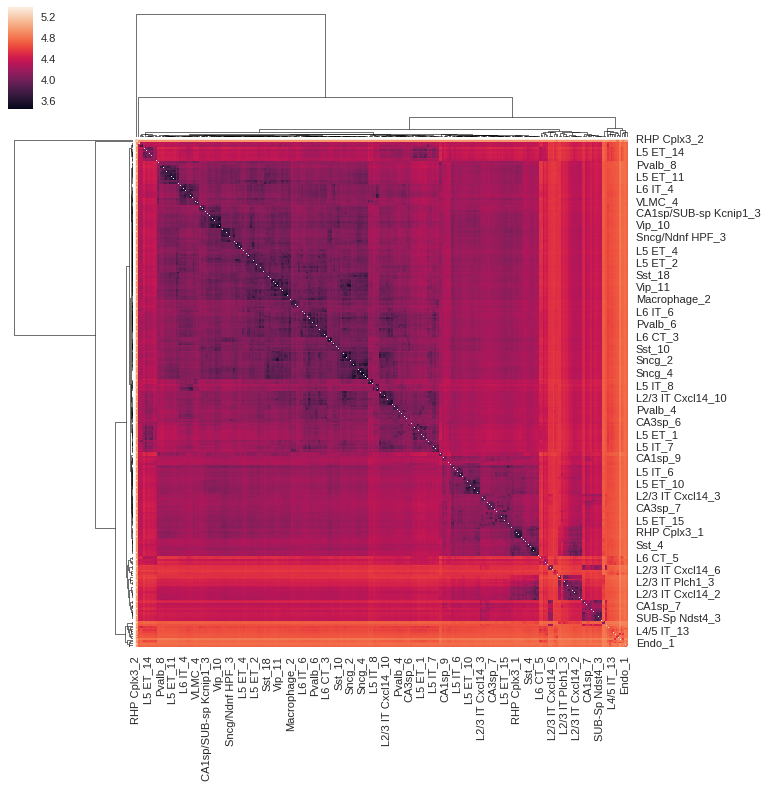

In [110]:
from sklearn.metrics.pairwise import euclidean_distances
import scipy.spatial as sp, scipy.cluster.hierarchy as shc
plt.style.use(['seaborn'])
dist = euclidean_distances(normalized_cell_type_averages, normalized_cell_type_averages)
linkage = shc.linkage(dist, method='average')
dist = np.log10(dist+1)
dist[range(n_cell_types),range(n_cell_types)]=np.nan
dist_df = pd.DataFrame(dist,index=cell_types,columns=cell_types)
sns.clustermap(dist_df, row_linkage=linkage, col_linkage=linkage)
plt.show()
plt.style.use(['dark_background'])

 [████████████████████████████████████████████████████████████] 290/290 [02:22<00:00, 0.49s/it]

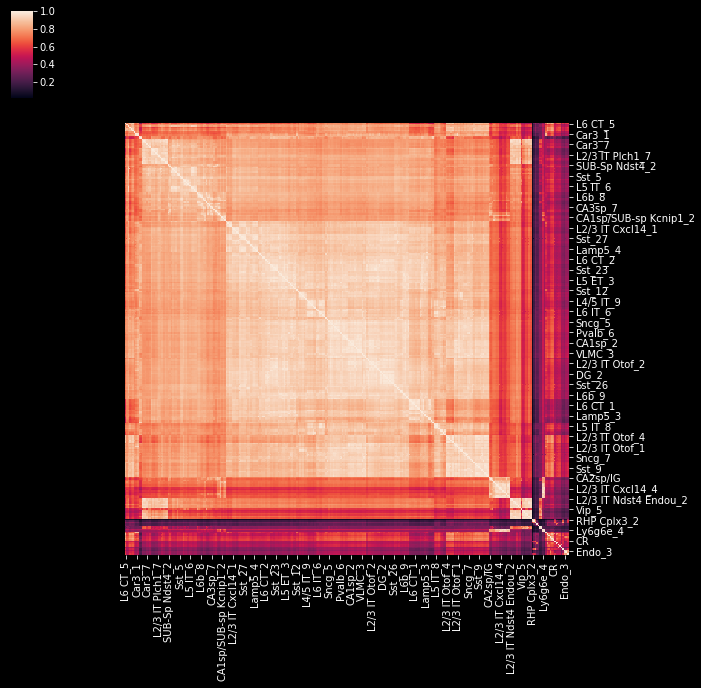

In [79]:
"""
Cell_type to Cell_type Weight Matrix using correlation
"""
cell_types = good_types
n_cell_types = len(cell_types)
average_weights_matrix = np.ones((n_cell_types,n_cell_types))
for x,cell1 in ipb(enumerate(cell_types),n_cell_types):
    X = normalized_cell_type_averages[x,:]
    for y,cell1 in enumerate(cell_types):
        if x<y:
            Y = normalized_cell_type_averages[y,:]
            weight = pearsonr(X,Y)[0]
            average_weights_matrix[x,y] = weight
            average_weights_matrix[y,x] = weight
average_weights_df = pd.DataFrame(average_weights_matrix,index=cell_types,columns=cell_types)
sns.clustermap(average_weights_df)
plt.show()

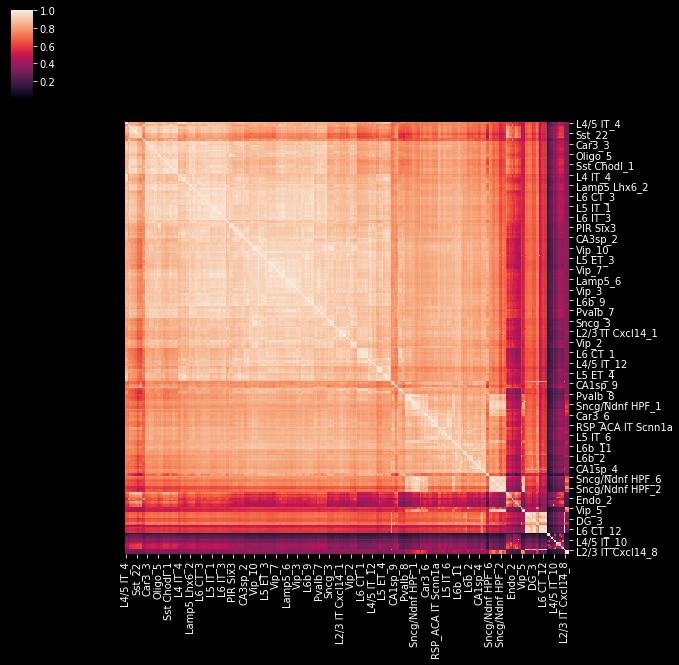

In [56]:
"""
Cell_type to Cell_type Weight Matrix using correlation
"""
cell_types = good_types
n_cell_types = len(cell_types)
weights_matrix = np.ones((n_cell_types,n_cell_types))
for x,cell1 in ipb(enumerate(cell_types),n_cell_types):
    X = normalized_cell_type_medians[x,:]
    for y,cell1 in enumerate(cell_types):
        if x<y:
            Y = normalized_cell_type_medians[y,:]
            weight = pearsonr(X,Y)[0]
            weights_matrix[x,y] = weight
            weights_matrix[y,x] = weight
weights_df = pd.DataFrame(weights_matrix,index=cell_types,columns=cell_types)
sns.clustermap(weights_df)
plt.show()

Covariance Matrix Generated


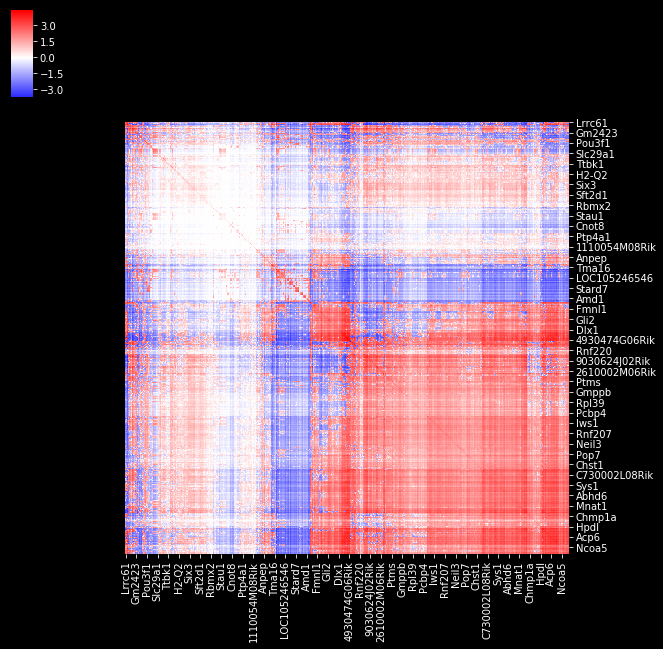

In [53]:
random_genes = random.sample(list(filtered_genes),500)
random_gene_filter = np.isin(filtered_genes,random_genes)
covariance_matrix = np.cov(filtered_medians[:,random_gene_filter].T)
log_covariance_matrix = np.log10(np.abs(covariance_matrix)+1)
log_covariance_matrix[covariance_matrix<0] = -log_covariance_matrix[covariance_matrix<0]
print('Covariance Matrix Generated')
sns.clustermap(pd.DataFrame(log_covariance_matrix,index=random_genes,columns=random_genes),cmap='bwr',center=0)
plt.show()

In [134]:
sorted_total_seperation['seperability'].min()

778.137552572543

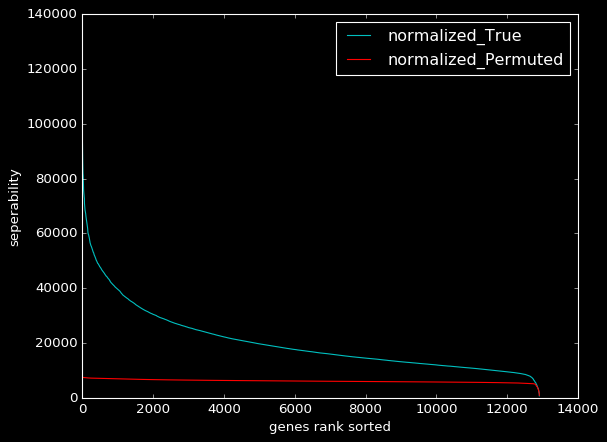

30513.214473959793


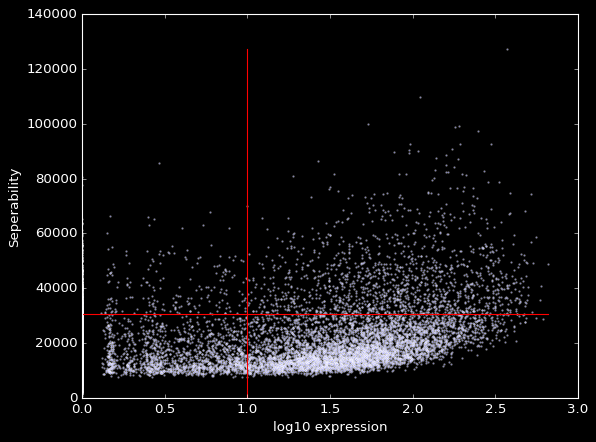

In [138]:
def calculate_seperability(filtered_medians,filtered_variances,weights,n_cell_types):
    seperability_matrix = np.zeros_like(filtered_medians)
    for i in ipb(range(n_cell_types),n_cell_types):
        median = filtered_medians[i,:]
        variance = filtered_variances[i,:]
        delta_medians = np.abs(np.subtract(filtered_medians,median[None,:]))
        sigma_variances = np.add(filtered_variances,variance[None,:])
        seperability = np.divide(delta_medians,sigma_variances)
        seperability[seperability==np.inf]=0
        weighted_seperability = np.divide(seperability,weights[i,:][:,None])
        weighted_seperability[weighted_seperability==np.inf]=0
        seperability_matrix[i,:] = np.nansum(weighted_seperability,axis=0)
    total_seperation = np.sum(seperability_matrix,axis=0)
    return total_seperation
"""
Calculate Seperability
"""
# total_seperation = calculate_seperability(filtered_averages,filtered_variances,weights_matrix,n_cell_types)
# permuted_seperation = calculate_seperability(permuted_filtered_averages,permuted_filtered_variances,weights_matrix,n_cell_types)

sorted_total_seperation = pd.DataFrame(total_seperation,index=filtered_genes,columns=['seperability']).sort_values('seperability',ascending=False)
sorted_permuted_seperation = pd.DataFrame(permuted_seperation,index=filtered_genes,columns=['seperability']).sort_values('seperability',ascending=False)
plt.style.use(['dark_background'])
plt.plot(np.array(range(len(sorted_total_seperation))),sorted_total_seperation,c='c',label='normalized_True')
plt.plot(np.array(range(len(sorted_permuted_seperation))),sorted_permuted_seperation,c='r',label='normalized_Permuted')
plt.xlabel('genes rank sorted')
plt.ylabel('seperability')
plt.ylim(bottom=0) 
plt.xlim(left=0) 
plt.legend()
plt.show()
# normalized_average_expression = pd.DataFrame(np.average(normalized_raw_counts[gene_filter,:],axis=1),index=filtered_genes)
sorted_total_seperation['expression'] = normalized_median_expression
plt.style.use(['dark_background'])
plt.scatter(np.log10(sorted_total_seperation['expression']+1),sorted_total_seperation['seperability'],s=1,alpha=0.5)
plt.plot([1,1],[0,np.max(sorted_total_seperation['seperability'])],c='r')
thresh = sorted_total_seperation['seperability'].iloc[2000]
print(thresh)
plt.plot([0,np.max(np.log10(sorted_total_seperation['expression']+1))],[thresh,thresh],c='r')
plt.xlabel('log10 expression')
plt.ylabel('Seperability')
plt.ylim(bottom=0) 
plt.xlim(left=0) 
plt.show()

In [137]:
len(sorted_total_seperation[sorted_total_seperation['seperability']>35000])

1413

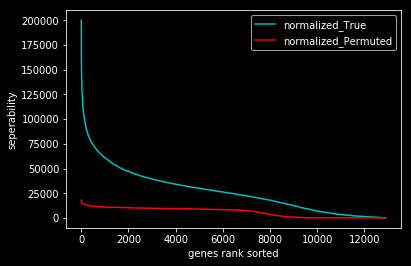

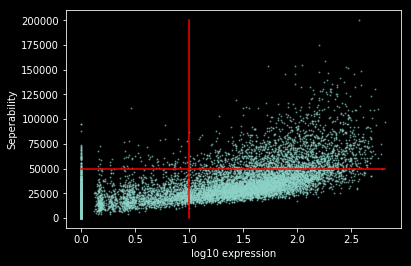

In [41]:
def calculate_seperability(filtered_medians,filtered_variances,weights,n_cell_types):
    seperability_matrix = np.zeros_like(filtered_medians)
    for i in ipb(range(n_cell_types),n_cell_types):
        median = filtered_medians[i,:]
        variance = filtered_variances[i,:]
        delta_medians = np.abs(np.subtract(filtered_medians,median[None,:]))
        sigma_variances = np.add(filtered_variances,variance[None,:])
        seperability = np.divide(delta_medians,sigma_variances)
        seperability[seperability==np.inf]=0
        weighted_seperability = np.divide(seperability,weights[i,:][:,None])
        weighted_seperability[weighted_seperability==np.inf]=0
        seperability_matrix[i,:] = np.nansum(weighted_seperability,axis=0)
    total_seperation = np.sum(seperability_matrix,axis=0)
    return total_seperation
"""
Calculate Seperability
"""
total_seperation = calculate_seperability(filtered_medians,filtered_variances,weights_matrix,n_cell_types)
permuted_seperation = calculate_seperability(permuted_filtered_medians,permuted_filtered_variances,weights_matrix,n_cell_types)

sorted_total_seperation = pd.DataFrame(total_seperation,index=filtered_genes,columns=['seperability']).sort_values('seperability',ascending=False)
sorted_permuted_seperation = pd.DataFrame(permuted_seperation,index=filtered_genes,columns=['seperability']).sort_values('seperability',ascending=False)
plt.style.use(['dark_background'])
plt.plot(np.array(range(len(sorted_total_seperation))),sorted_total_seperation,c='c',label='normalized_True')
plt.plot(np.array(range(len(sorted_permuted_seperation))),sorted_permuted_seperation,c='r',label='normalized_Permuted')
plt.xlabel('genes rank sorted')
plt.ylabel('seperability')
plt.legend()
plt.show()
normalized_median_expression = pd.DataFrame(np.median(normalized_raw_counts[gene_filter,:],axis=1),index=filtered_genes)
sorted_total_seperation['expression'] = normalized_median_expression
plt.style.use(['dark_background'])
plt.scatter(np.log10(sorted_total_seperation['expression']+1),sorted_total_seperation['seperability'],s=1,alpha=0.5)
plt.plot([1,1],[0,np.max(sorted_total_seperation['seperability'])],c='r')
plt.plot([0,np.max(np.log10(sorted_total_seperation['expression']+1))],[50000,50000],c='r')
plt.xlabel('log10 expression')
plt.ylabel('Seperability')
plt.show()

In [45]:
print(len(sorted_total_seperation[sorted_total_seperation['seperability']>50000]))
seperability_filtered_genes = np.array(sorted_total_seperation[sorted_total_seperation['seperability']>50000].index)
seperability_gene_filter = np.isin(filtered_genes,seperability_filtered_genes)
seperability_filtered_medians = filtered_medians[:,seperability_gene_filter]
seperability_filtered_variances = filtered_variances[:,seperability_gene_filter]

1699


In [144]:
seperability_filtered_genes = np.array(sorted_total_seperation.iloc[:2000].index)
seperability_gene_filter = np.isin(filtered_genes,seperability_filtered_genes)
seperability_filtered_averages = filtered_averages[:,seperability_gene_filter]
seperability_filtered_medians = filtered_medians[:,seperability_gene_filter]
seperability_filtered_variances = filtered_variances[:,seperability_gene_filter]

In [ ]:
"""
Backup Filtered Genes
"""

"""
Load from Backup
"""


Covariance Matrix Generated


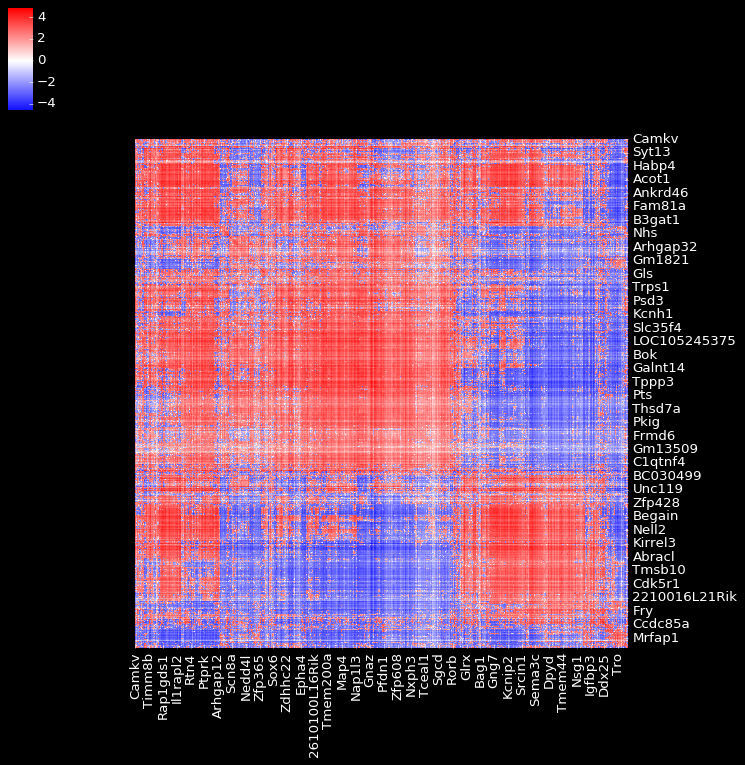

In [140]:
covariance_matrix = np.cov(seperability_filtered_medians.T)
log_covariance_matrix = np.log10(np.abs(covariance_matrix)+1)
log_covariance_matrix[covariance_matrix<0] = -log_covariance_matrix[covariance_matrix<0]
print('Covariance Matrix Generated')
sns.clustermap(pd.DataFrame(log_covariance_matrix,index=seperability_filtered_genes,columns=seperability_filtered_genes),cmap='bwr',center=0)
plt.show()

In [142]:
seperability_filtered_medians.shape

(290, 2000)

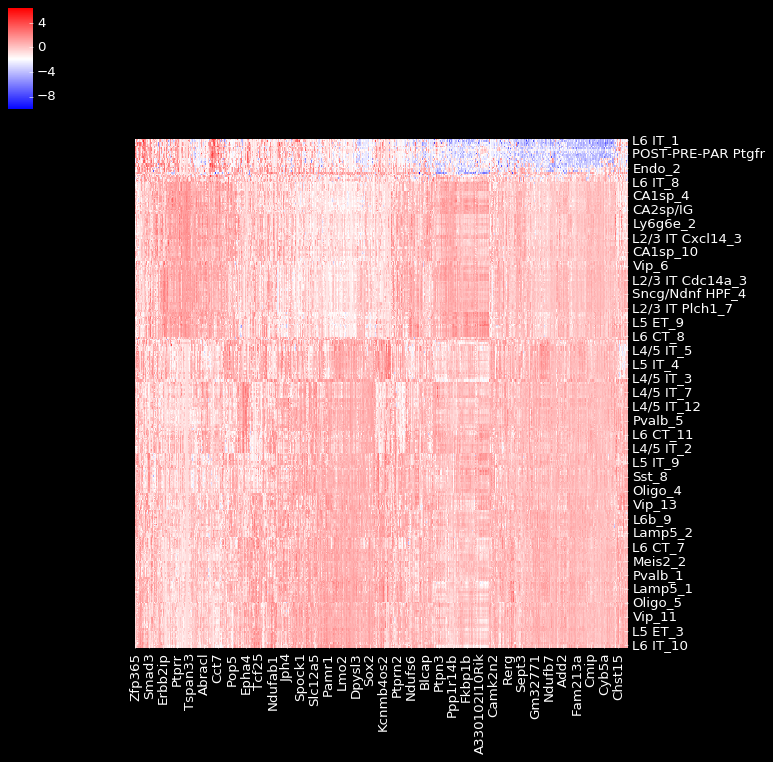

In [148]:
sns.clustermap(pd.DataFrame(np.log10(seperability_filtered_averages+1),index=cell_types,columns=seperability_filtered_genes),cmap='bwr',z_score=1)
plt.show()

In [ ]:
"""
Making sure all cell types get some genes
"""


In [150]:
len(filtered_genes)

12907

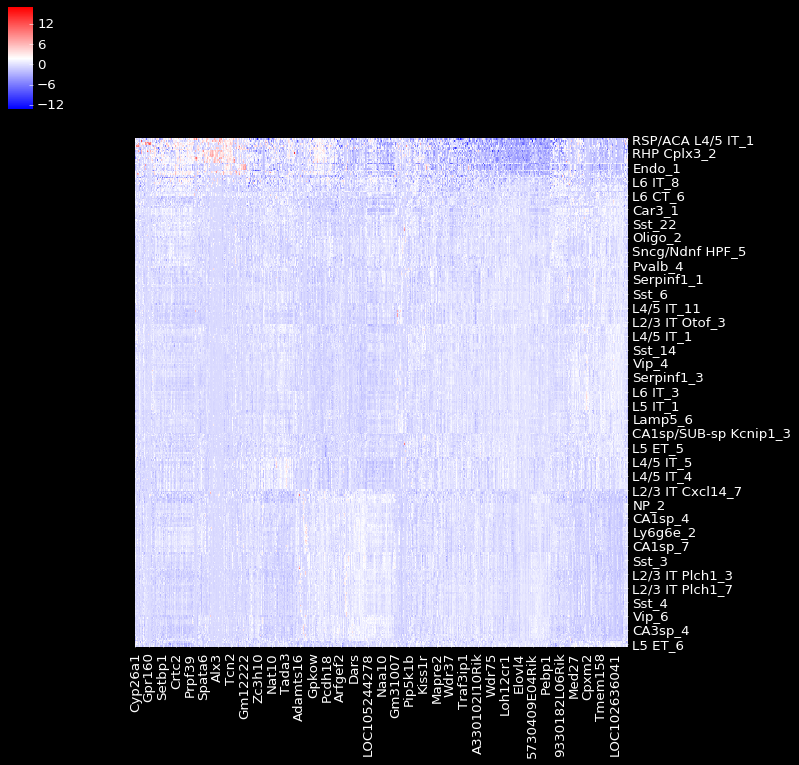

In [149]:
sns.clustermap(pd.DataFrame(np.log10(filtered_averages+1),index=cell_types,columns=filtered_genes),cmap='bwr',z_score=1)
plt.show()